# Academic success in high schools: What drives differences in SAT-scores across NYC?
## Motivation 
The results of the standardized "SAT"-exam is used by US-colleges to determine which high school graduates they admit. 
Understanding if there are any unintended patterns or reasons discriminating against certain groups of students is an important step to making the US education system more equal - something the US Department of Education states as a "formidable challenge".

To be an informed citizen on this matter and to refine my python skills, I want to know:
- Which factors drive differences in SAT-scores and thus opportunities to attend (selective) US-colleges?

## Methodology

This analysis will use descriptive statistics (e.g. mean, correlations) and data visualizations (e.g. scatter plots, bar charts, maps) to explore the following datasets on NYC high schools:

- <a href='https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4'>SAT scores by school - SAT scores for each high school in New York City</a>
- <a href='https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt'>School attendance - Attendance information for each school in New York City</a>
- <a href='https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3'>Class size - Information on class size for each school</a>
- <a href='https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e'>AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)</a>
- <a href='https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a'>Graduation outcomes - The percentage of students who graduated, and other outcome information</a>
- <a href='https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j'>Demographics - Demographic information for each school</a>
- <a href='https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8'>School survey - Surveys of parents, teachers, and students at each school</a>

__NB!This project is carried out according to the <a href='https://www.dataquest.io'>dataquest</a> instructions.__

## Findings

The main findings are:

- Consistent with serious research, Hispanic and black students are at a disadvantage. They are schooled in less safe neighbourhoods and less often admitted to their borough's elite high schools.
- There are no achievement gaps on the SAT between male and female students.
- Advanced Placement (AP) courses are not always good preparation for SAT-tests.

## Data Exploration
### Read in the data

In [1]:
import pandas as pd
import numpy
import re

# enable visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# enable image export
import os 


pyo.init_notebook_mode(connected=True)

if not os.path.exists("images"):
    os.mkdir("images")

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




## Data Cleaning
### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Data Analysis
### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"].sort_values()
print(correlations)

frl_percent                            -0.722225
sped_percent                           -0.448170
ell_percent                            -0.398750
hispanic_per                           -0.396985
black_per                              -0.284139
ell_num                                -0.153778
lon                                    -0.132222
lat                                    -0.121029
com_p_11                               -0.115073
male_per                               -0.112062
zip                                    -0.063977
rr_t                                   -0.023386
eng_p_11                                0.020254
hispanic_num                            0.025744
black_num                               0.027979
sped_num                                0.034933
aca_p_11                                0.035155
eng_t_11                                0.036906
CSD                                     0.042948
rr_p                                    0.047925
com_tot_11          

In [10]:
# columns with considerable correlation
corr_cols = ['saf_tot_11', 'Total Cohort', 'aca_s_11', 'NUMBER OF SECTIONS','total_enrollment', 
             'AVERAGE CLASS SIZE','total_students', 'N_s', 'Total Exams Taken', 'AP Test Takers ',
             'frl_percent','sped_percent', 'ell_percent', 'hispanic_per']

correlations[corr_cols].sort_values()

frl_percent          -0.722225
sped_percent         -0.448170
ell_percent          -0.398750
hispanic_per         -0.396985
saf_tot_11            0.318753
Total Cohort          0.325144
aca_s_11              0.339435
NUMBER OF SECTIONS    0.362673
total_enrollment      0.367857
AVERAGE CLASS SIZE    0.381014
total_students        0.407827
N_s                   0.423463
Total Exams Taken     0.514333
AP Test Takers        0.523140
Name: sat_score, dtype: float64

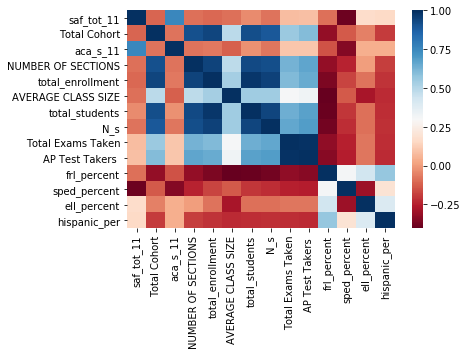

In [11]:
corr = combined[corr_cols].corr()

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

### Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Text(0.5,1.04,'Correlation of SAT score and \nthe survey responses')

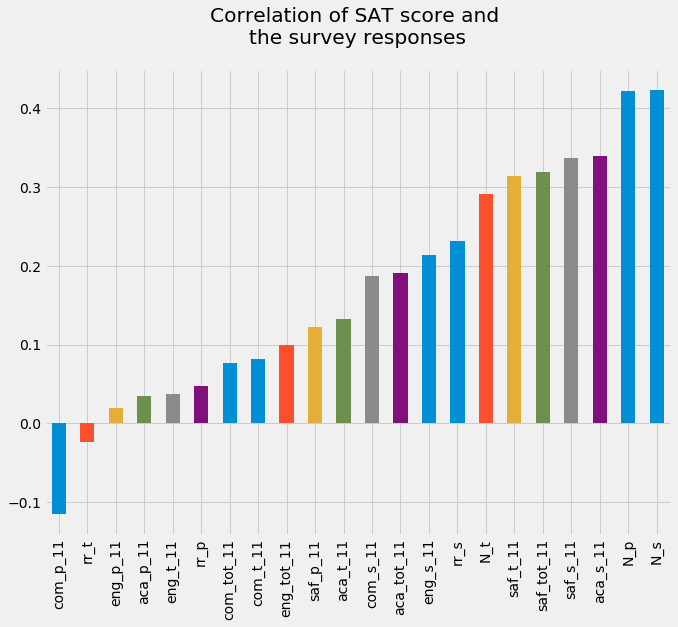

In [13]:
%matplotlib inline
plt.style.use('fivethirtyeight')

combined.corr()["sat_score"][survey_fields].sort_values().plot.bar(figsize=(10,8))
plt.title("Correlation of SAT score and \nthe survey responses", y = 1.04)

There are high correlations between __N_s__ *(number of student respondents)*, __N_t__ *(number of teacher respondents)*, __N_p__ *(Number of parent respondents)* and __sat_score__. Since these columns are also correlated with __total_enrollment__, it is logical that they would be high.

It is more interesting that __rr_s__, *the student response rate*, or the percentage of students that completed the survey, correlates with __sat_score__. Perhaps, students who filled out surveys tend to be more diligent and responsible, so these qualities help them do well academically.

Safety perception among students and teachers (__saf_t_11__ and __saf_s_11__) also correlates with __sat_score__. This makes sense, as an unsafe learning environment creates hindrances both for teaching and learning.

The last interesting correlation is between __aca_s_11__, which indicates how students perceive academic standards, __sat_score__ columns, but this is not true for __aca_t_11__ *(how teachers perceive academic standards)*, or __aca_p_11__ *(how parents perceive academic standards)*.

### Exploring the impact of Safety Perception on the SAT

The graph below vividly illustrates that __students from the NYC schools with low safety perception index are less likely to succeed on the SAT__. Moreover, the average SAT score at schools with the safety perception index equal to or lower than 6.5 does not go beyond 1333 (out of 2400). Meanwhile, the average SAT score at schools with relatively higher safety perception index can make up to 2096.

Interestingly, __school size__ (total number of students) __does not affect performance on the SAT__. Therefore, students from both big and small schools have an equal chance either to pass or fail the test.

In [14]:
# build scatter plot to map average SAT score and Safety Perception index in each school
fig = go.Figure(data=go.Scatter(x=combined['saf_tot_11'], y=combined['sat_score'], 
                   marker=dict(
                       size=combined['Total Cohort']/25,
                       color=combined['saf_tot_11'], #set color equal to a variable
                       colorscale='Viridis',
                       showscale=True), 
                   mode='markers', text=combined['SCHOOL NAME']))

fig.add_shape(
        # add horizontal line
        dict(
            type="line",
            x0=4.7,
            y0=combined['sat_score'].mean(),
            x1=9.5,
            y1=combined['sat_score'].mean(),
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.add_shape(
        # add vertical line
        dict(
            type="line",
            x0=combined['saf_tot_11'].mean(),
            y0=830,
            x1=combined['saf_tot_11'].mean(),
            y1=2220,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.update_layout(
    title="The NYC Schools: <br>SAT Score vs Safety and Respect Perception index",
    xaxis_title="Safety and Respect Perception Index",
    yaxis_title="SAT score"
)
fig.show()
fig.write_image("images/safety_sat.png")

In [15]:
unsafe_schools = combined[combined['saf_tot_11']<=6.5]
safe_schools = combined[combined['saf_tot_11']>6.5]
print("Average SAT Score for schools with low safety perception index: {:04.0f}".format(unsafe_schools['sat_score'].max()))
print("Average SAT Score for schools with adequate safety perception index: {:04.0f}".format(safe_schools['sat_score'].max()))

Average SAT Score for schools with low safety perception index: 1333
Average SAT Score for schools with adequate safety perception index: 2096


### Exploring racial differences on the SAT 
There are a few columns in our dataframe that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

In [16]:
race_cols = ['white_per','asian_per','black_per','hispanic_per']

# build scatter plot to visualize correlation between SAT score and race of students
corr_race = combined[['sat_score','white_per','asian_per','black_per','hispanic_per']].corr()['sat_score'][race_cols]
x = corr_race.index
y = corr_race.values
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['% of white students','% of asian students','% of black students','% of Hispanic students'],
            marker={'color':y,'colorscale': 'Viridis'})])
fig.update_layout(title_text='The NYC Schools: <br>Correlation of SAT score and shares of various races/ethnicities')
fig.show()

As we see, strong correlation between __white_per__, __asian_per__ and __sat_score__ may suggest that white and asian students tend to have higher SAT scores compared to the students from the other racial groups. 

Negative correlation between __black_per__, __hispanic_per__ and __sat_score__ confirms particularly high achievement gaps for these two group of students.  

We can also explore distribution by race across

In [17]:
# assume that 'elite schools' are those with an average SAT score higher than 1800 
elite_schools = combined[combined['sat_score']>1800] 

# build bar plot to visualize racial makeup of elite schools vs all the NYC schools 
num_race = ['white_per','asian_per','black_per','hispanic_per']

elite_distr = {}
ordinary_disrt = {}

for i in num_race:
    elite_distr[i] = int(((elite_schools[i]/100)*elite_schools['Total Cohort']).sum()/(elite_schools['Total Cohort'].sum())*100)
    ordinary_disrt[i] = int(((combined[i]/100)*combined['Total Cohort']).sum()/(combined['Total Cohort'].sum())*100)


x=['Elite schools','All schools']
fig = go.Figure(go.Bar(x=x, y=[elite_distr['white_per'],ordinary_disrt['white_per']], name='White students'))
fig.add_trace(go.Bar(x=x, y=[elite_distr['asian_per'],ordinary_disrt['asian_per']], name='Asian students'))
fig.add_trace(go.Bar(x=x, y=[elite_distr['black_per'],ordinary_disrt['black_per']], name='Black students'))
fig.add_trace(go.Bar(x=x, y=[elite_distr['hispanic_per'],ordinary_disrt['hispanic_per']], name='Hispanic students'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'},
                  title='The NYC schools: <br> Distribution by race/ethnicity. <br>All VS Elite schools (average SAT score > 1800)',
                  yaxis_title="Percentage of certain racial/ethnic group")
fig.show()

In [18]:
# build scatter plot to map SAT score and share of Hispanics in each school 

fig = go.Figure(data=go.Scatter(x=combined['hispanic_per'], y=combined['sat_score'], 
                   marker=dict(
                       size=combined['Total Cohort']/25,
                       color=combined['hispanic_per'], 
                       colorscale='Viridis',
                       showscale=True), 
                   mode='markers', text=combined['SCHOOL NAME']))

fig.add_shape(
        # add horizontal line
        dict(
            type="line",
            x0=-10,
            y0=combined['sat_score'].mean(),
            x1=110,
            y1=combined['sat_score'].mean(),
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.add_shape(
        # add vertical line
        dict(
            type="line",
            x0=combined['hispanic_per'].mean(),
            y0=800,
            x1=combined['hispanic_per'].mean(),
            y1=2240,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.update_layout(
    title="The NYC schools: <br>SAT score VS share of Hispanics",
    xaxis_title="Percentage of Hispanic students",
    yaxis_title="SAT score"
)
fig.show()

- The __schools in the far right corner__ appear to be primarily geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores. 

- Many of the __schools on the upper left side__ appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low share of Hispanics at those schools, but it does tell us why their students tend to do better on the SAT –– they are students from all over New York City who did well on a standardized test.

### Exploring gender differences on the SAT 
There are two columns in our dataset that indicate percentage of students by gender:

- male_per
- female_per

We will plot out the correlations between the percentage of students by gender and SAT score to determine if there are any achievement gaps.

AxesSubplot(0.08,0.07;0.87x0.81)


Text(0.5,1.04,'Correlation of SAT score and \nstudents by gender')

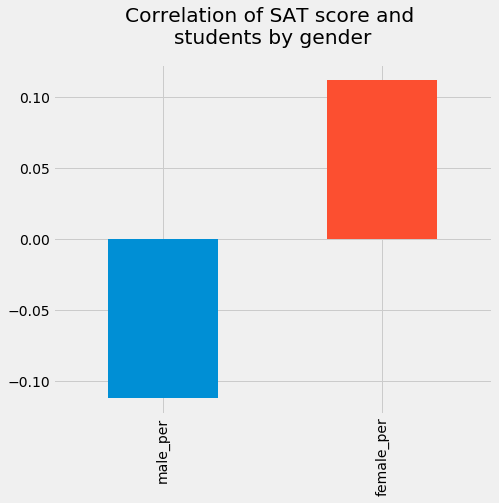

In [19]:
print(combined[['sat_score','male_per','female_per']].corr()['sat_score'][['male_per','female_per']].plot.bar(figsize=(7,6)))
plt.title("Correlation of SAT score and \nstudents by gender", y = 1.04)

The graph above indicates that __correlation of SAT score and students by gender is weak__. That leads us to the conclusion that gender does not determine success on the SAT.  

However, it may be worth looking at schools with high share of female or male students. To achieve that, I will build a scatter plot to see if there are any NYC high schools with gender imbalances. 

In [20]:
#build scatter plot to map SAT score and share of female students per each school 

fig = go.Figure(data=go.Scatter(x=combined['female_per'], y=combined['sat_score'],
                   marker=dict(
                       size=15,
                       color = combined['female_per'],
                       colorscale='Viridis',
                       opacity=0.4),
                   mode='markers',marker_line_width=1.5,text=combined['SCHOOL NAME']))

fig.add_shape(
        # add horizonal line
        dict(
            type="line",
            x0=-8,
            y0=combined['sat_score'].mean(),
            x1=108,
            y1=combined['sat_score'].mean(),
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.add_shape(
        # add vertical line
        dict(
            type="line",
            x0=50,
            y0=800,
            x1=50,
            y1=2200,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.update_layout(
    title="The NYC schools: <br>SAT score VS share of female students",
    xaxis_title="Share of female students",
    yaxis_title="SAT score",
)
fig.show()

The horizontal line of the graph indicates the average SAT score across NYC high schools. Whereas the vertical line stands for the point where shares of female and male students are equal. We can interpret the graph in several ways. Firstly, it shows that most of the NYC high schools are clustered around the intersection of two lines. Thus, we can confirm our previous suggestion that there is __no difference in SAT scores across male and female students__. Moreover, the better half of __the NYC high schools have more or less equal gender representation__.

However, if we look at the extreme values on both sides of the graph, we will notice one interesting pattern. __Schools with predominantly female students__ (_share of females > 60%_) tend to __specialize in liberal arts__. Whereas __high schools with the majority of male students__ (_share of females < 40%_) __are mainly technical schools__.

## Exploring SAT scores among AP Test takers

In [21]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]*100

#build scatter plot to map SAT score and share of female students per each school 

fig = go.Figure(data=go.Scatter(x=combined['ap_per'], y=combined['sat_score'],
                   marker=dict(
                       size=15,
                       color = combined['ap_per'],
                       colorscale='Viridis',
                       opacity=0.4),
                   mode='markers',marker_line_width=1.5,text=combined['SCHOOL NAME']))

fig.add_shape(
        # add horizonal line
        dict(
            type="line",
            x0=-8,
            y0=combined['sat_score'].mean(),
            x1=108,
            y1=combined['sat_score'].mean(),
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.add_shape(
        # add vertical line
        dict(
            type="line",
            x0=combined['ap_per'].mean(),
            y0=800,
            x1=combined['ap_per'].mean(),
            y1=2200,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"
            )
))

fig.update_layout(
    title="The NYC schools:<br> SAT score VS share of AP Test takers",
    xaxis_title="Percentage of AP Test Takers",
    yaxis_title="SAT score",
)
fig.show()

__Advanced Placement (AP)__ is a program in the United States and Canada created by the College Board which offers college-level curricula and examinations to high school students.

According to the graph above we can make two distinct observations:
- __Schools with SAT score above 1400__ tend to be selective college-preparatory public high schools with admission based on rigorous academic standards and criteria. It is not surprising that students from those school succeed on the SAT.
- __Schools with SAT score below 1400 and above-average share of AP-test takers__ mainly cater to otherwise disadvantaged students. The range of AP courses is little and often limits to English literature and language - it is surprising, that these schools nonetheless score low on SAT's reading and writing sections.
- __Schools with average SAT score and very high shares of AP-test takers__ most probably had missing data, so their SAT score was imputed. They are there not investigated any further.

All in all, it looks like the share of AP-test takers is not a strong indicator for SAT-performance.

## Exploring districts with schools with the highest SAT score

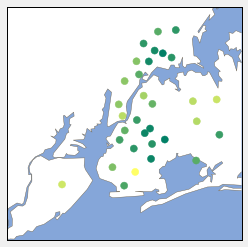

In [22]:
from pylab import rcParams

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
rcParams['figure.figsize'] = (12,10)

plt.show()

The graph shows that high SAT scores can be expected from schools that are located either in Manhattan, Staten Island and some parts of Brooklyn and Queens. 
## Conclusions
__NB__: This was mainly a technical challenge to learn data analysis techniques and tools in Python. Please refer to "results" at the beginning of this document or the respective headings of the individual sections for an overview of insights gained from the data.

In this guided project we have applied the learnings of Step 2 of Dataquest's "Data Analyst" learning path. Some of the concepts include:

- data aggregation using pandas methods like 'groupby;
- regular expressions;
- vectorized string operations;
- combining dataset with joins and concatenation;
- plotting with matplotlib and plotly.